In [6]:
#General packages
import numpy as np
import pandas as pd
from pymongo import MongoClient
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
import collections
import json

#Figure packages
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import plotly.express as px
import plotly.io as pio
import matplotlib.ticker as ticker

#custom packages
import query_builder
import grocery_base

# Figure Display Settings

In [2]:
font_size =12

SMALL_SIZE = font_size
MEDIUM_SIZE = font_size
BIGGER_SIZE = font_size

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

matplotlib.rcParams['font.serif'] = "Times New Roman"
matplotlib.rcParams['font.family'] = "serif"
sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})
# sns.set_style("white")
# sns.set_style("ticks")
sns.set(style="ticks", font="Times New Roman", font_scale=1.5)

In [3]:
#https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth', 0)

display(HTML("<style>.container { width:85% !important; }</style>"))

## Connect and Process MongoDB data

In [20]:
gdb_df=pd.read_csv('GroceryDB_foods.csv')
print(len(gdb_df))

50468


C:\Users\sobek\AppData\Local\Temp\ipykernel_4312\498686545.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  gdb_df=pd.read_csv('GroceryDB_foods.csv')


In [21]:
# Open and load the JSON file
with open('UpdatedProductIngredients_11_15.json', 'r') as file:
    ing_list=json.load(file)

In [22]:
# Function to flatten json
def flatten_ingredients(product_name,original_id,ingredients,parent_order=0,depth=1):
    rows=[]

    for ingredient in ingredients:
        # Calculate distance to first node
        distance_to_root=ingredient.get('order',0)+parent_order

        # Extract ingredient information, calculated distance, depth, and parent_order
        row = {
            'product_name': product_name,
            'original_ID': original_id,
            'ingredient_name': ingredient.get('ingredient_name'),
            'original_text': ingredient.get('original_text'),
            'general_name': ingredient.get('general_name'),
            'ingredient_type': ingredient.get('ingredient_type'),
            'order': ingredient.get('order'),
            'descriptors': ingredient.get('descriptors', []),
            'parent_order': parent_order,
            'distance_to_root': distance_to_root,
            'depth': depth
        }
        rows.append(row)

        # Rerun function for sub-ingredients
        if ingredient.get('sub_ingredients'):
            rows.extend(flatten_ingredients(product_name,original_id,
                ingredient['sub_ingredients'],parent_order=distance_to_root,depth=depth+1
            ))

    return rows

In [23]:
#Convert json into Dataframe
all_rows=[]
for product in ing_list:
    product_name=product.get('product_name')
    original_id=product.get('original_ID') 
    if product_name and product.get('ingredient_tree'):  
        all_rows.extend(flatten_ingredients(product_name,original_id,product['ingredient_tree']))

p_ingred=pd.DataFrame(all_rows)
len(p_ingred)

610766

In [24]:
#Calculate the width and depth of each product ingredient tree
p_ingred['tree_width']=None
p_ingred['sum_tree_depth']=None
p_ingred['ingred_count']=None

prods=p_ingred['original_ID'].unique()

for prod_id in tqdm(prods):
    S=p_ingred[p_ingred['original_ID']==prod_id]
    tree_width=S[S['parent_order']==0]['order'].max()
    sum_tree_depth=len(S[['parent_order','depth']].drop_duplicates())
    p_ingred.loc[S.index,'tree_width']=tree_width
    p_ingred.loc[S.index,'ingred_count']=len(S)
    if len(S)<=1:
        p_ingred.loc[S.index,'sum_tree_depth']=0
    else:
        p_ingred.loc[S.index,'sum_tree_depth']=sum_tree_depth

100%|██████████| 42540/42540 [18:40<00:00, 37.98it/s]


In [25]:
# Combine information from gdb_df into p_ingred
merged_df = p_ingred.merge(
    gdb_df[['original_ID','store','harmonized single category','f_FPro','has10_nuts','is_Nuts_Converted_100g']],
    on='original_ID', how='left')
p_ingred['store'] = merged_df['store']
p_ingred['harmonized single category'] = merged_df['harmonized single category']
p_ingred['f_FPro'] = merged_df['f_FPro']
p_ingred['has10_nuts'] = merged_df['has10_nuts']
p_ingred['is_Nuts_Converted_100g'] = merged_df['is_Nuts_Converted_100g']

In [32]:
#Filter ingredient trees
ingred_df=p_ingred[(p_ingred['is_Nuts_Converted_100g']==1) & (p_ingred['has10_nuts']==1)]
ingred_df=ingred_df.dropna(subset=['f_FPro']).reset_index(drop=True)
len(ingred_df)

378001

In [33]:
ingred_df['f_FPro'].describe()

count    378001.000000
mean     0.820157     
std      0.147137     
min      0.000000     
25%      0.742031     
50%      0.853419     
75%      0.936611     
max      0.999056     
Name: f_FPro, dtype: float64

# Approximate FPro for Ingreds

In [42]:
#Calculate 1/distance
ingred_df['ingred_distance_rank'] = (
    1 / (ingred_df['distance_to_root'] + 0)
)

#For ingredients with multiple entries in list, keep the largest 
producs_ingreds_spec_df = (
    ingred_df
    .sort_values('distance_to_root')
    .drop_duplicates(['original_ID','general_name'], keep='first')
)

#Calculate normalization term per ingredient
producs_ingreds_spec_df = pd.merge(
    producs_ingreds_spec_df,
    (
        producs_ingreds_spec_df.groupby('general_name')
        .agg(ingred_normalization_term = ('ingred_distance_rank','sum'))
        .reset_index()
    ),
    on='general_name', how='left'
)
producs_ingreds_spec_df['ingred_normalization_term'] = producs_ingreds_spec_df['ingred_normalization_term'].astype(float)

In [43]:
#Function for Calculating IgFPro
def weighted_avg(r):
    ingred_normalization_term = r['ingred_normalization_term']
    ingred_normalization_term = ingred_normalization_term.unique()
    
    if len(ingred_normalization_term) != 1:
        raise Exception('HOW!!!')
    ingred_normalization_term = ingred_normalization_term[0]
    
    res = (r['ingred_distance_rank'] * r['f_FPro']).sum() / ingred_normalization_term
    
    return pd.Series({'ingred_FPro': res})

In [44]:
#Determine the IgFPro per Ingredient
producs_ingreds_spec_df = pd.merge(
    producs_ingreds_spec_df,
    (
        producs_ingreds_spec_df
        .groupby('general_name')
        .apply(weighted_avg)
        .reset_index()
    ),
    on='general_name', how='left'
)

In [54]:
#Count Occurrences of each ingredient
count_ingreds=(
    producs_ingreds_spec_df.groupby(['general_name'])
    .agg(count_ingred=('original_ID', np.size))
    .sort_values(['count_ingred'], ascending=False)
    .reset_index()
)

producs_ingreds_spec_df = producs_ingreds_spec_df.merge(
    count_ingreds[['general_name','count_ingred']],
    on='general_name', how='left')

In [56]:
producs_ingreds_spec_df[['ingred_distance_rank', 'ingred_normalization_term', 'ingred_FPro']].describe()

,ingred_distance_rank,ingred_normalization_term,ingred_FPro
count,331275.000000,331275.000000,331275.000000
mean,0.230558,545.286864,0.797753
std,0.239226,934.894546,0.089909
min,0.011111,0.014493,0.000056
25%,0.090909,38.186947,0.750811
50%,0.142857,173.001836,0.802277
75%,0.250000,507.780856,0.865908
max,1.000000,4581.462401,0.998111


# Figure S18

In [78]:
ingreds_FPro_df = producs_ingreds_spec_df.groupby(['general_name']).agg(
    count_products = ('original_ID', lambda x: len(set(x))),
    ingred_FPro = ('ingred_FPro','mean'),
    avg_FPro_products = ('f_FPro','mean'),
    
    avg_distance_root = ('distance_to_root','mean'),
    ingred_normalization_term = ('ingred_normalization_term','mean')
)

ingreds_FPro_df = ingreds_FPro_df.reset_index().sort_values('ingred_FPro', ascending=False)

if False:
    path_output = 'output/ingreds_approx_FPro_ingred_col_{}.xlsx'.format(col_ingred_name)
    ingreds_FPro_df.to_excel(path_output)

1675


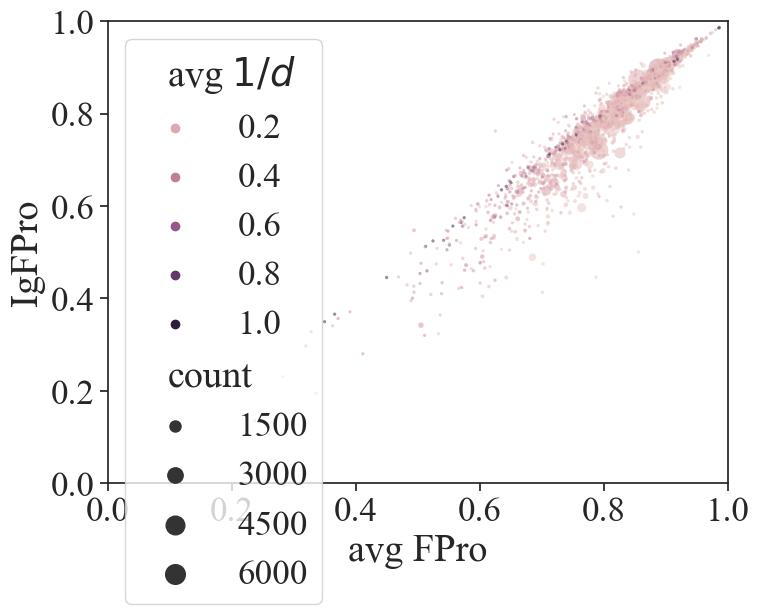

In [116]:
count_products_min = 10

ingreds_FPro_df['avg_distance_root rank'] =  1 / ingreds_FPro_df['avg_distance_root']
ingreds_FPro_df['count_products log'] =  ingreds_FPro_df['count_products'].apply(np.log)

data_plot_df = ingreds_FPro_df[ingreds_FPro_df['count_products'] >= count_products_min].sort_values(by='count_products', ascending=False)

fig, axs = plt.subplots(1, figsize=(8, 6), dpi=100)

print(len(data_plot_df))

g = sns.scatterplot(
    data=data_plot_df[data_plot_df['count_products'] < 9000], 
    x="avg_FPro_products", y="ingred_FPro",
    hue='avg_distance_root rank', alpha=0.5, linewidth=0, 
    size='count_products', sizes=(5, 200), size_norm=(1, 5000)
)

leg = g.axes.get_legend()
leg.set_title('')
for i, t in enumerate(leg.texts):
    if i == 0:
        t.set_text('avg $1/d$')
    if i == 6:
        t.set_text('count')
    pass

g.set(ylim=(0, 1), xlim=(0, 1))
g.set(xlabel='avg FPro', ylabel='IgFPro')

if False:
    g.set(title='count_products_min: {} | col_ingred_name: {}'.format(count_products_min, col_ingred_name))
    
#plt.savefig('output/figS19.pdf')
plt.savefig("output/figS19.svg", format='svg')

# Figure 6a

In [86]:
ingreds_FPro_ranked = (
    ingreds_FPro_df[ingreds_FPro_df['count_products'] >= count_products_min]
    .sort_values('ingred_FPro', ascending=True)
    .reset_index(drop=True)
    .reset_index(drop=False)
    .rename(columns={'index': 'rank'})
)

ingreds_FPro_ranked['avg_distance_root log'] = ingreds_FPro_ranked['avg_distance_root'].apply(np.log)
ingreds_FPro_ranked['avg_distance_root rank'] =  1 / ingreds_FPro_ranked['avg_distance_root']
ingreds_FPro_ranked['count_products log'] = ingreds_FPro_ranked['count_products'].apply(np.log)

count_products_min: 10 | col_ingred_name: general_name | num ingreds: 1675


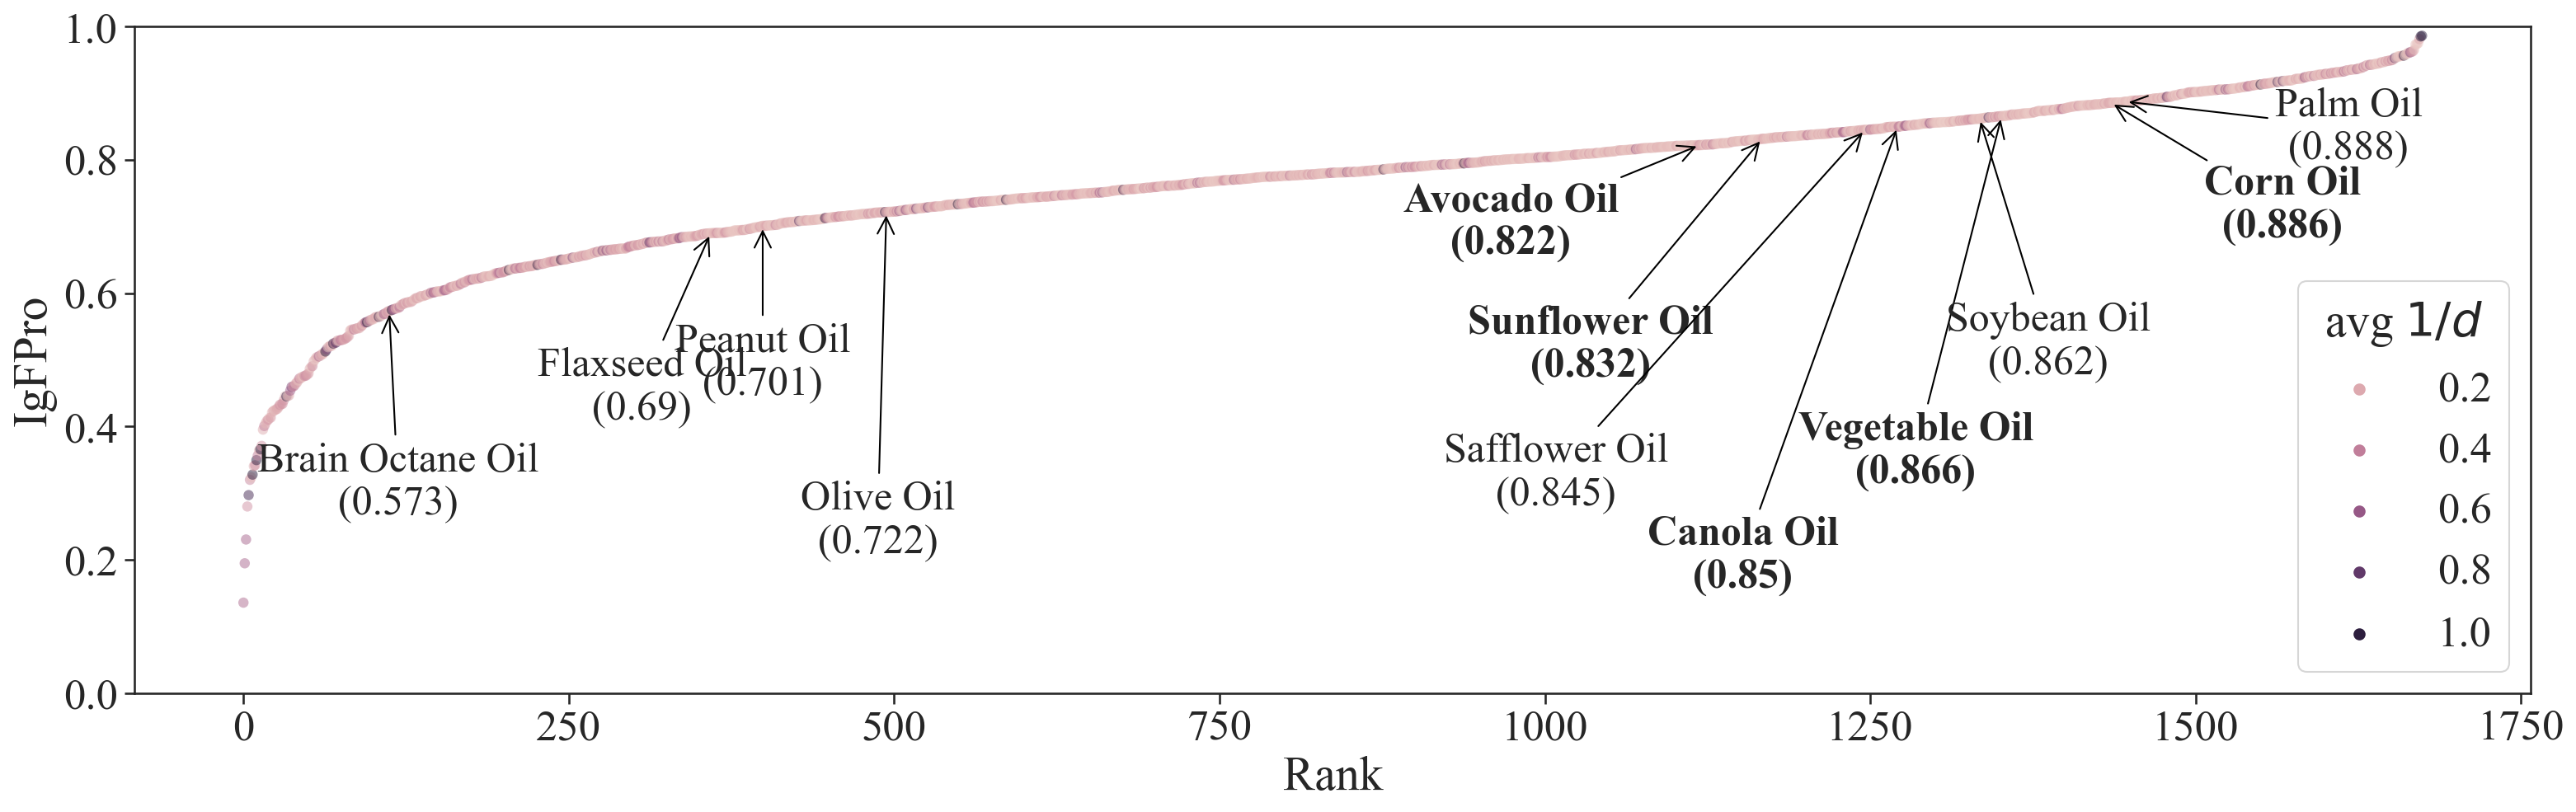

In [96]:
def annotate(g, data_df, ingred, xytext, fontsize, dround=3, write_IgFPro=False, bold=False):   
    x_val = data_df[data_df['general_name'] == ingred]['rank'].values[0]
    y_val = data_df[data_df['general_name'] == ingred]['ingred_FPro'].values[0]
    
    font_weight = None
    if write_IgFPro:
#         ingred = ingred + '\n({:.03f})'.format(y_val)
        ingred = ingred + '\n({})'.format(round(y_val, dround))
        
        if bold:
            font_weight = 'bold'
    
    g.annotate(
        text=ingred.title(), weight=font_weight,
        xy=(x_val, y_val),
        xycoords='data',
        fontsize=fontsize,
        xytext=xytext, 
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='black'),  # Use color black
        horizontalalignment='center',  # Center horizontally
        verticalalignment='center'  # Center vertically
    )
    pass


def plot_IGFPro(font_scale, figsize, dpi, annot_fontsize,verbose):
    count_products_min = 10

    sns.set(style="ticks", font="Times New Roman", font_scale=font_scale)

    # (15, 6)
    fig, axs = plt.subplots(1, figsize=figsize, dpi=dpi)

    g = sns.scatterplot(
        data=ingreds_FPro_ranked, 
        x="rank", y="ingred_FPro",
        hue='avg_distance_root rank', alpha=0.5, linewidth=0, 
    )

    g.set(ylim=(0, 1.0))
    
    #Highlight oils in plot
    annotate(g, ingreds_FPro_ranked, ingred='brain octane oil', xytext=(5, -100),fontsize=annot_fontsize,write_IgFPro=True)
    annotate(g, ingreds_FPro_ranked, ingred='flaxseed oil', xytext=(-40, -90),fontsize=annot_fontsize,write_IgFPro=True)
    annotate(g, ingreds_FPro_ranked, ingred='olive oil', xytext=(-5, -180),fontsize=annot_fontsize,write_IgFPro=True)
    annotate(g, ingreds_FPro_ranked, ingred='peanut oil', xytext=(0, -80),fontsize=annot_fontsize,write_IgFPro=True)
    annotate(g, ingreds_FPro_ranked, ingred='avocado oil', xytext=(-110, -45),write_IgFPro=True,fontsize=annot_fontsize,bold=True)
    annotate(g, ingreds_FPro_ranked, ingred='sunflower oil', xytext=(-100, -120),write_IgFPro=True,fontsize=annot_fontsize,bold=True)
    annotate(g, ingreds_FPro_ranked, ingred='canola oil', xytext=(-90, -250),write_IgFPro=True,fontsize=annot_fontsize,bold=True)
    annotate(g, ingreds_FPro_ranked, ingred='vegetable oil', xytext=(-50, -195),write_IgFPro=True,fontsize=annot_fontsize,bold=True)
    annotate(g, ingreds_FPro_ranked, ingred='soybean oil', xytext=(40, -130),write_IgFPro=True,fontsize=annot_fontsize,dround=3)
    annotate(g, ingreds_FPro_ranked, ingred='safflower oil', xytext=(-180, -200),write_IgFPro=True,fontsize=annot_fontsize)
    annotate(g, ingreds_FPro_ranked, ingred='corn oil', xytext=(100, -60),write_IgFPro=True,fontsize=annot_fontsize,bold=True,dround=3)
    annotate(g, ingreds_FPro_ranked, ingred='palm oil', xytext=(130, -15),fontsize=annot_fontsize,write_IgFPro=True)
    #annotate(g, ingreds_FPro_ranked, ingred='palm kernel oil', xytext=(-10, -40),fontsize=annot_fontsize)

    plt.legend(title='avg $1/d$')
    g.set(xlabel='Rank', ylabel='IgFPro')

    t_text = 'count_products_min: {} | col_ingred_name: {} | num ingreds: {}'.format(
            count_products_min, 'general_name', len(ingreds_FPro_ranked))
    
    if verbose:
        g.set(title=t_text)
    else:
        print(t_text)
    
    return ingreds_FPro_ranked

ingreds_FPro_ranked = plot_IGFPro(font_scale=2.3, figsize=(25, 7), dpi=150,annot_fontsize=24,verbose=False)
plt.savefig('output/fig6a.pdf', bbox_inches='tight')

### HTML Interactive Versions of Figure 6a

In [98]:
fig = px.scatter(ingreds_FPro_ranked, x="rank", y="ingred_FPro", color='avg_distance_root rank',
                hover_data=['general_name', 'count_products', 'avg_distance_root', 'avg_FPro_products'])
# fig.show()
# pio.show(fig)
pio.write_html(fig, file='output/IgFPro_index_1.html', auto_open=True)

In [100]:
# avg_FPro_products
print(stats.spearmanr(ingreds_FPro_ranked['avg_distance_root'], ingreds_FPro_ranked['ingred_FPro']))

ingreds_FPro_ranked['avg_distance_root log'] = ingreds_FPro_ranked['avg_distance_root'].apply(np.log)

fig = px.scatter(ingreds_FPro_ranked, x="avg_distance_root", y="ingred_FPro", color='avg_FPro_products',
                hover_data=['general_name', 'count_products', 'avg_FPro_products'])
pio.write_html(fig, file='output/IgFPro_index_2.html', auto_open=True)

SignificanceResult(statistic=0.22827612432114683, pvalue=3.055584129809952e-21)


In [ ]:
if False:
    ingreds_FPro_ranked.to_excel('output/ingreds_FPro_ranked_042822.xlsx')